# Exploring the Future of Urban Mobility: A Deep Dive into YouBike 2.0 in Taipei City

## Outline

1. Introduction
2. Dataset
3. Exploratory Data Analysis
   - 3.1 Station / Grid Service Level
   - 3.2 Route and Route Popularity

## 1. Introduction

YouBike, Taiwan's leading public bicycle system, offers 24/7 point-to-point rental and return services, transforming the way residents and visitors navigate urban spaces. With the introduction of YouBike 2.0, featuring a new design for both bikes and stations, the system no longer relies on external electricity, making it more flexible and easier to deploy across the city. This project, YouBike Route Explorer, delves into the deployment strategy of YouBike 2.0 in Taipei City, empowers you to explore usage patterns, popular routes, and how these trends reflect the evolving needs of urban commuters. By preparing and analyzing dataset with this notebook and "seeing" the data with this [exploratory data visualization tool](https://github.com/TimJJTing/YouBike-Route-Explorer), we can uncover insights that could drive more efficient, accessible, and sustainable transportation solutions.

## 2. Dataset

The datasets for this project come from

- [臺北市YouBike見車率統計](https://data.taipei/dataset/detail?id=ba0dafae-043c-4730-b97e-2defd7af766c)
  - 站點ID(stop_id)
  - 站點名稱(stop_name)
  - 車柱數(capacity)
  - 經度(lng)
  - 緯度(lat)
  - 見車等級(category)
  - 點座標(geometry)
- [臺北市YouBike起訖站點統計](https://data.taipei/dataset/detail?id=c7dbdb7c-6bbd-495a-bd23-49b22defd83e)
  - 借車站點ID(on_stop_id)
  - 還車站點ID(off_stop_id)
  - 借車站點名稱(on_stop)
  - 還車站點名稱(off_stop)
  - 交易次數(sum_of_txn_times)
  - 借車站點行政區(TOWNNAME_origin)
  - 還車站點行政區(TOWNNAME_destination)
  - 建議視覺化線寬(width)
  - 線座標(geometry)
- [臺北市YouBike區域互補站點](https://data.taipei/dataset/detail?id=fe8a0ddd-6f70-4e63-92a1-a3463c790a1b)
  - times（互補人數）
  - stop_id1（站點ID1）
  - longitude1（經度）
  - latitude1（緯度）
  - stop_id2（站點ID2）
  - longitude2
  - latitude2

All datasets were originally processed in July 2023.

## 3. Exploratory Data Analysis

In this project we use
- `pandas` and `geopandas` for data cleansing and geospatial processing
- `h3` to index geospatial features into hexagonal grids for ease of further aggregation
- `seaborn` and `matplotlib` to visualize data during the EDA process

In [1]:
import pandas as PD
import geopandas as GPD
import h3 as H3
import seaborn as SNS
import matplotlib.pyplot as PLT

### 3.1 Station / Grid Service Level

In [2]:
# import dataset, data time 2023-07
yb_service_level = PD.read_csv("./dataset/見車率_202307.csv") # station data
yb_service_level

,stop_id,stop_name,capacity,latitude,longitude,category
0,U101001,捷運科技大樓站,28,25.02605,121.54360,中
1,U101002,復興南路二段273號前,21,25.02565,121.54357,中
2,U101003,國北教大實小東側門,16,25.02429,121.54124,中
3,U101004,和平公園東側,11,25.02351,121.54282,中
4,U101005,辛亥復興路口西北側,16,25.02153,121.54299,中
...,...,...,...,...,...,...
1285,U119087,臺大總圖書館西南側,30,25.01690,121.54031,中
1286,U119088,臺大黑森林西側,20,25.01995,121.54347,中
1287,U119089,臺大獸醫館南側,24,25.01791,121.54242,中
1288,U119090,臺大新體育館東南側,40,25.02112,121.53591,高


In [3]:
yb_service_level.dtypes

stop_id       object
stop_name     object
capacity       int64
latitude     float64
longitude    float64
category      object
dtype: object

In [4]:
yb_service_level.describe()

,capacity,latitude,longitude
count,1290.000000,1290.000000,1290.000000
mean,22.906977,25.052645,121.544501
std,12.112379,0.032850,0.031637
min,5.000000,24.976190,121.462880
25%,15.000000,25.029802,121.521903
50%,20.000000,25.049395,121.540385
75%,28.000000,25.072055,121.566145
max,99.000000,25.145820,121.623060


In [5]:
# use int32 for capacity to avoid from wasting memory
yb_service_level = yb_service_level.astype({"capacity": "int32"})
yb_service_level.dtypes

stop_id       object
stop_name     object
capacity       int32
latitude     float64
longitude    float64
category      object
dtype: object

In [6]:
# add h3 lv9 cell index
yb_service_level["h3_cell_lv9"] = yb_service_level.apply(
    lambda x: H3.latlng_to_cell(x["latitude"], x["longitude"], 9), axis=1
)
yb_service_level

,stop_id,stop_name,capacity,latitude,longitude,category,h3_cell_lv9
0,U101001,捷運科技大樓站,28,25.02605,121.54360,中,894ba0a432fffff
1,U101002,復興南路二段273號前,21,25.02565,121.54357,中,894ba0a432fffff
2,U101003,國北教大實小東側門,16,25.02429,121.54124,中,894ba0a432bffff
3,U101004,和平公園東側,11,25.02351,121.54282,中,894ba0a432fffff
4,U101005,辛亥復興路口西北側,16,25.02153,121.54299,中,894ba0a5d93ffff
...,...,...,...,...,...,...,...
1285,U119087,臺大總圖書館西南側,30,25.01690,121.54031,中,894ba0a5dd7ffff
1286,U119088,臺大黑森林西側,20,25.01995,121.54347,中,894ba0a5d83ffff
1287,U119089,臺大獸醫館南側,24,25.01791,121.54242,中,894ba0a5d8bffff
1288,U119090,臺大新體育館東南側,40,25.02112,121.53591,高,894ba0a4363ffff


In [7]:
# export dataset as parquet
yb_service_level.to_parquet("./parquet/yb_stations_tpc.parquet")

#### Grid Service Level of Taipei City

In [8]:
# compute grid service level
grid_service_level = yb_service_level.groupby(["h3_cell_lv9"])[["capacity"]].sum().reset_index()
grid_service_level

,h3_cell_lv9,capacity
0,894ba0a4003ffff,16
1,894ba0a400bffff,54
2,894ba0a400fffff,52
3,894ba0a4013ffff,60
4,894ba0a4017ffff,52
...,...,...
812,894ba5696c7ffff,39
813,894ba5696cbffff,40
814,894ba5696cfffff,15
815,894ba5696d3ffff,44


In [9]:
grid_service_level["capacity"].describe()

count    817.000000
mean      36.168911
std       26.858852
min        8.000000
25%       18.000000
50%       30.000000
75%       45.000000
max      286.000000
Name: capacity, dtype: float64

#### Adding All Grids in Taipei City

In [10]:
# Load official shp file
tw_county_df = GPD.read_file("./dataset/geodata/COUNTY_MOI_1130718.shp")
tw_county_df

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,Z,09007,連江縣,Lienchiang County,"MULTIPOLYGON (((119.96446 25.94552, 119.96428 ..."
1,G,10002,宜蘭縣,Yilan County,"MULTIPOLYGON (((121.95972 24.84493, 121.96065 ..."
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.45656 24.20718, 120.48589 24.197..."
3,M,10008,南投縣,Nantou County,"POLYGON ((121.27087 24.23661, 121.27108 24.236..."
4,P,10009,雲林縣,Yunlin County,"MULTIPOLYGON (((120.08108 23.52412, 120.08161 ..."
5,T,10013,屏東縣,Pingtung County,"MULTIPOLYGON (((120.82649 21.75615, 120.82646 ..."
6,C,10017,基隆市,Keelung City,"MULTIPOLYGON (((121.71016 25.17604, 121.71016 ..."
7,A,63000,臺北市,Taipei City,"POLYGON ((121.57099 25.19717, 121.57098 25.197..."
8,F,65000,新北市,New Taipei City,"POLYGON ((121.53753 25.30003, 121.53769 25.300..."
9,B,66000,臺中市,Taichung City,"POLYGON ((121.32835 24.43304, 121.32846 24.432..."


In [11]:
# extract Taipei city
tpe_df = tw_county_df[tw_county_df["COUNTYID"] == "A"]
tpe_df.crs

<Geographic 2D CRS: GEOGCS["GCS_TWD97[2020]",DATUM["Taiwan_Datum_1997" ...>
Name: GCS_TWD97[2020]
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: Taiwan_Datum_1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
# Converting to EPSG:4326/WGS84
tpe_df = tpe_df.to_crs(epsg=4326)
tpe_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
geo = tpe_df.geometry
# geo.__geo_interface__
# {'type': 'FeatureCollection',
#  'features': [{'id': '7',
#    'type': 'Feature',
#    'properties': {},
#    'geometry': {'type': 'Polygon',
#     'coordinates': (((121.57098851600006, 25.19716545800003),
#       (121.57098033600005, 25.197032453000077),
#       (121.57094175000009, 25.196889465000027),
#       (121.57092440600002, 25.19682197000003),
#       ...

In [14]:
# transfrom geofeatures to h3 grids (resolution level 9)
cells = H3.geo_to_cells(geo.__geo_interface__["features"][0]["geometry"], res=9)
cells[:20]

['894ba0a6c27ffff',
 '894ba0a6bcbffff',
 '894ba0a6b6fffff',
 '894ba0a6b13ffff',
 '894ba0a6ab7ffff',
 '894ba0a6a5bffff',
 '894ba0a69a3ffff',
 '894ba0a6947ffff',
 '894ba0b4d6fffff',
 '894ba0a688fffff',
 '894ba0a6833ffff',
 '894ba0b4ba3ffff',
 '894ba1d3683ffff',
 '894ba0a6c83ffff',
 '894ba0b4b47ffff',
 '894ba1d3627ffff',
 '894ba1d35cbffff',
 '894ba0b4a8fffff',
 '894ba569ecbffff',
 '894ba0b4a33ffff']

In [15]:
# transform the cell array to a series of indecies in dataframe for joining
tpe_grid_service_df = PD.DataFrame(data={"h3_cell_lv9": cells}).set_index("h3_cell_lv9")
tpe_grid_service_df

""
h3_cell_lv9
894ba0a6c27ffff
894ba0a6bcbffff
894ba0a6b6fffff
894ba0a6b13ffff
894ba0a6ab7ffff
...
894ba0a6c73ffff
894ba0a6c17ffff
894ba0a6bbbffff


In [16]:
# join dataframes
tpe_grid_service_df = tpe_grid_service_df.join(grid_service_level.set_index("h3_cell_lv9")).fillna(0).astype({"capacity": "int32"})
tpe_grid_service_df

,capacity
h3_cell_lv9,
894ba0a6c27ffff,21
894ba0a6bcbffff,0
894ba0a6b6fffff,33
894ba0a6b13ffff,0
894ba0a6ab7ffff,0
...,...
894ba0a6c73ffff,22
894ba0a6c17ffff,0
894ba0a6bbbffff,61


In [17]:
tpe_grid_service_df.dtypes

capacity    int32
dtype: object

In [18]:
# TODO: name each grid

In [19]:
# export dataset as parquet
tpe_grid_service_df.to_parquet("./parquet/yb_grids_tpc.parquet")

### 3.2 Route and Route Popularity

#### Data Preparation

In [20]:
# import dataset, data time 2023-07
yb_route_weekday = PD.read_csv("./dataset/yb_rent_return_weekday.csv") # routing data
yb_route_weekday

,on_stop_id,off_stop_id,on_stop,off_stop,sum_of_txn_times,district_origin,district_destination,width
0,U101001,U101001,捷運科技大樓站,捷運科技大樓站,332,大安區,大安區,2.392846
1,U101001,U101002,捷運科技大樓站,復興南路二段273號前,109,大安區,大安區,1.454463
2,U101001,U101003,捷運科技大樓站,國北教大實小東側門,98,大安區,大安區,1.408176
3,U101001,U101004,捷運科技大樓站,和平公園東側,345,大安區,大安區,2.447550
4,U101001,U101005,捷運科技大樓站,辛亥復興路口西北側,1028,大安區,大安區,5.321611
...,...,...,...,...,...,...,...,...
261129,U106067,U216006,臺北轉運站,扶輪公園,1,中山區,林口區,1.000000
261130,U107014,U216019,伊通長安路口,仁愛文化二路口,1,中山區,林口區,1.000000
261131,U110078,U216008,捷運南京三民站(3號出口),三井Outlet,2,松山區,林口區,1.004208
261132,U105030,U212002,臺北市立景美女中,淡蘭吊橋,1,文山區,石碇區,1.000000


In [21]:
yb_route_weekday.describe()

,sum_of_txn_times,width
count,261134.000000,261134.000000
mean,11.011002,1.042126
std,46.997994,0.197767
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.004208
75%,7.000000,1.025248
max,3328.000000,15.000000


In [22]:
yb_route_weekday.dtypes

on_stop_id               object
off_stop_id              object
on_stop                  object
off_stop                 object
sum_of_txn_times          int64
district_origin          object
district_destination     object
width                   float64
dtype: object

In [23]:
yb_route_weekday = yb_route_weekday.astype({"sum_of_txn_times": "int32"})

In [24]:
yb_service_level.set_index("stop_id", inplace=True)

In [25]:
def get_stop_data(df, keyword, col):
    data = None
    try:
        data = df.loc[keyword, col]
    except:
        pass
        # print(keyword, " not found")
    return data

In [26]:
# add columns from station data
yb_route_weekday["on_lat"]  = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["on_stop_id"], "latitude"), axis=1)
yb_route_weekday["on_lon"]  = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["on_stop_id"], "longitude"), axis=1)
yb_route_weekday["on_cell"] = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["on_stop_id"], "h3_cell_lv9"), axis=1)
yb_route_weekday["off_lat"]  = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["off_stop_id"], "latitude"), axis=1)
yb_route_weekday["off_lon"]  = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["off_stop_id"], "longitude"), axis=1)
yb_route_weekday["off_cell"] = yb_route_weekday.apply(lambda x: get_stop_data(yb_service_level, x["off_stop_id"], "h3_cell_lv9"), axis=1)
yb_route_weekday

,on_stop_id,off_stop_id,on_stop,off_stop,sum_of_txn_times,district_origin,district_destination,width,on_lat,on_lon,on_cell,off_lat,off_lon,off_cell
0,U101001,U101001,捷運科技大樓站,捷運科技大樓站,332,大安區,大安區,2.392846,25.02605,121.54360,894ba0a432fffff,25.02605,121.54360,894ba0a432fffff
1,U101001,U101002,捷運科技大樓站,復興南路二段273號前,109,大安區,大安區,1.454463,25.02605,121.54360,894ba0a432fffff,25.02565,121.54357,894ba0a432fffff
2,U101001,U101003,捷運科技大樓站,國北教大實小東側門,98,大安區,大安區,1.408176,25.02605,121.54360,894ba0a432fffff,25.02429,121.54124,894ba0a432bffff
3,U101001,U101004,捷運科技大樓站,和平公園東側,345,大安區,大安區,2.447550,25.02605,121.54360,894ba0a432fffff,25.02351,121.54282,894ba0a432fffff
4,U101001,U101005,捷運科技大樓站,辛亥復興路口西北側,1028,大安區,大安區,5.321611,25.02605,121.54360,894ba0a432fffff,25.02153,121.54299,894ba0a5d93ffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261129,U106067,U216006,臺北轉運站,扶輪公園,1,中山區,林口區,1.000000,25.04842,121.51994,894ba0a40b3ffff,NaN,NaN,None
261130,U107014,U216019,伊通長安路口,仁愛文化二路口,1,中山區,林口區,1.000000,25.04833,121.53469,894ba0a41c7ffff,NaN,NaN,None
261131,U110078,U216008,捷運南京三民站(3號出口),三井Outlet,2,松山區,林口區,1.004208,25.05129,121.56426,894ba0a4c0fffff,NaN,NaN,None
261132,U105030,U212002,臺北市立景美女中,淡蘭吊橋,1,文山區,石碇區,1.000000,24.98058,121.55624,894ba0a5b17ffff,NaN,NaN,None


In [27]:
# drop rows with na, we are not interested in intercity trip. drop useless columns
yb_route_weekday_tpc = yb_route_weekday.drop(["district_origin", "district_destination"], axis=1).dropna()
yb_route_weekday_tpc = yb_route_weekday_tpc.rename(
    columns={
        "on_stop_id": "on_id",
        "off_stop_id": "off_id",
        "on_stop": "on_name",
        "off_stop": "off_name"
    }
)
yb_route_weekday_tpc

,on_id,off_id,on_name,off_name,sum_of_txn_times,width,on_lat,on_lon,on_cell,off_lat,off_lon,off_cell
0,U101001,U101001,捷運科技大樓站,捷運科技大樓站,332,2.392846,25.02605,121.5436,894ba0a432fffff,25.02605,121.54360,894ba0a432fffff
1,U101001,U101002,捷運科技大樓站,復興南路二段273號前,109,1.454463,25.02605,121.5436,894ba0a432fffff,25.02565,121.54357,894ba0a432fffff
2,U101001,U101003,捷運科技大樓站,國北教大實小東側門,98,1.408176,25.02605,121.5436,894ba0a432fffff,25.02429,121.54124,894ba0a432bffff
3,U101001,U101004,捷運科技大樓站,和平公園東側,345,2.447550,25.02605,121.5436,894ba0a432fffff,25.02351,121.54282,894ba0a432fffff
4,U101001,U101005,捷運科技大樓站,辛亥復興路口西北側,1028,5.321611,25.02605,121.5436,894ba0a432fffff,25.02153,121.54299,894ba0a5d93ffff
...,...,...,...,...,...,...,...,...,...,...,...,...
241839,U113073,U113066,青年路152巷口,青年公園3號出口,49,1.201984,25.01979,121.5009,894ba0a42cbffff,25.02273,121.50271,894ba0a42c3ffff
241840,U113073,U113068,青年路152巷口,捷運龍山寺站(1號出口)_1,5,1.016832,25.01979,121.5009,894ba0a42cbffff,25.03548,121.50026,894ba0a463bffff
241841,U113073,U113069,青年路152巷口,莒光社會住宅,5,1.016832,25.01979,121.5009,894ba0a42cbffff,25.03170,121.50033,894ba0a4677ffff
241842,U113073,U113071,青年路152巷口,萬大路493巷,15,1.058912,25.01979,121.5009,894ba0a42cbffff,25.01975,121.49920,894ba0a42cbffff


In [28]:
yb_route_weekday_tpc.describe()

,sum_of_txn_times,width,on_lat,on_lon,off_lat,off_lon
count,241793.000000,241793.000000,241793.000000,241793.000000,241793.000000,241793.000000
mean,11.683229,1.044955,25.046034,121.542645,25.046203,121.542103
std,48.733289,0.205069,0.024866,0.025510,0.025559,0.026013
min,1.000000,1.000000,24.976190,121.462880,24.976190,121.462880
25%,1.000000,1.000000,25.029310,121.524500,25.028700,121.523570
50%,3.000000,1.008416,25.042970,121.540370,25.043110,121.539950
75%,8.000000,1.029456,25.057310,121.557660,25.058040,121.557640
max,3328.000000,15.000000,25.145820,121.623060,25.145820,121.623060


In [29]:
yb_route_weekday_tpc.dtypes

on_id                object
off_id               object
on_name              object
off_name             object
sum_of_txn_times      int32
width               float64
on_lat              float64
on_lon              float64
on_cell              object
off_lat             float64
off_lon             float64
off_cell             object
dtype: object

#### Looping Routes

In [30]:
# inspect case when on_stop == off_stop
yb_route_weekday_tpc[yb_route_weekday_tpc["on_id"] == yb_route_weekday_tpc["off_id"]].describe()

,sum_of_txn_times,width,on_lat,on_lon,off_lat,off_lon
count,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,145.722611,1.608992,25.052692,121.544506,25.052692,121.544506
std,126.525669,0.532419,0.032822,0.031672,0.032822,0.031672
min,1.000000,1.000000,24.976190,121.462880,24.976190,121.462880
25%,60.000000,1.248272,25.029870,121.521810,25.029870,121.521810
50%,111.000000,1.462879,25.049420,121.540400,25.049420,121.540400
75%,190.500000,1.797415,25.072010,121.566290,25.072010,121.566290
max,1265.000000,6.318906,25.145820,121.623060,25.145820,121.623060


#### Visualize Station to Staion Popularity

In [31]:
# Pivot the DataFrame to create a matrix
matrix = yb_route_weekday_tpc.pivot(index="on_id", columns="off_id", values="sum_of_txn_times")


<Axes: xlabel='off_id', ylabel='on_id'>

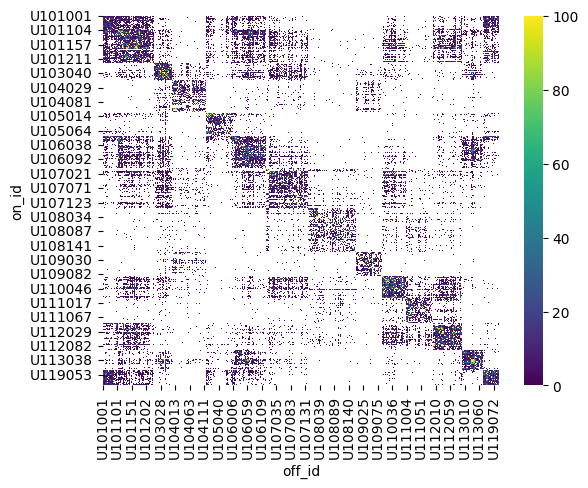

In [32]:
SNS.heatmap(matrix, fmt="g", cmap="viridis", vmin=0, vmax=100)

#### Visualize Grid to Grid Popularity

In [33]:
# aggregate 'sum_of_txn_times' by grid index
h3_agg = yb_route_weekday_tpc.groupby(["on_cell", "off_cell"])[["sum_of_txn_times"]].sum().reset_index()
h3_agg

,on_cell,off_cell,sum_of_txn_times
0,894ba0a4003ffff,894ba0a4003ffff,230
1,894ba0a4003ffff,894ba0a400bffff,30
2,894ba0a4003ffff,894ba0a400fffff,26
3,894ba0a4003ffff,894ba0a4013ffff,44
4,894ba0a4003ffff,894ba0a4017ffff,253
...,...,...,...
127011,894ba5696dbffff,894ba5696c7ffff,10
127012,894ba5696dbffff,894ba5696cbffff,237
127013,894ba5696dbffff,894ba5696cfffff,7
127014,894ba5696dbffff,894ba5696d3ffff,45


In [34]:
# inspect case when on_cell == off_cell
h3_agg[h3_agg["on_cell"] == h3_agg["off_cell"]].describe()

,sum_of_txn_times
count,816.000000
mean,274.186275
std,297.136951
min,1.000000
25%,90.000000
50%,184.000000
75%,357.250000
max,2362.000000


In [35]:
h3_agg.describe()

,sum_of_txn_times
count,127016.000000
mean,22.240686
std,100.641098
min,1.000000
25%,1.000000
50%,3.000000
75%,12.000000
max,6906.000000


In [36]:
h3_agg.dtypes

on_cell             object
off_cell            object
sum_of_txn_times     int32
dtype: object

In [37]:
# Pivot the DataFrame to create a matrix
h3_matrix = h3_agg.pivot(index="on_cell", columns="off_cell", values="sum_of_txn_times")

<Axes: xlabel='off_cell', ylabel='on_cell'>

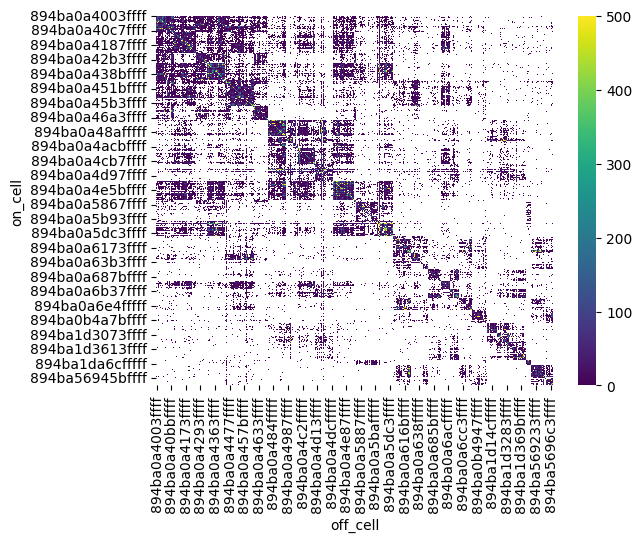

In [38]:
SNS.heatmap(h3_matrix, fmt="g", cmap="viridis", vmin=0, vmax=500)

In [39]:
# add centroids of the grids
h3_agg["on_lat"] = h3_agg.apply(
    lambda x: H3.cell_to_latlng(x["on_cell"])[0], axis=1
)
h3_agg["on_lon"] = h3_agg.apply(
    lambda x: H3.cell_to_latlng(x["on_cell"])[1], axis=1
)
h3_agg["off_lat"] = h3_agg.apply(
    lambda x: H3.cell_to_latlng(x["off_cell"])[0], axis=1
)
h3_agg["off_lon"] = h3_agg.apply(
    lambda x: H3.cell_to_latlng(x["off_cell"])[1], axis=1
)
# add missing values
h3_agg["on_id"] = h3_agg["on_cell"]
h3_agg["on_name"] = h3_agg["on_cell"]
h3_agg["off_id"] = h3_agg["off_cell"]
h3_agg["off_name"] = h3_agg["off_cell"]
h3_agg

,on_cell,off_cell,sum_of_txn_times,on_lat,on_lon,off_lat,off_lon,on_id,on_name,off_id,off_name
0,894ba0a4003ffff,894ba0a4003ffff,230,25.041169,121.517518,25.041169,121.517518,894ba0a4003ffff,894ba0a4003ffff,894ba0a4003ffff,894ba0a4003ffff
1,894ba0a4003ffff,894ba0a400bffff,30,25.041169,121.517518,25.038326,121.516431,894ba0a4003ffff,894ba0a4003ffff,894ba0a400bffff,894ba0a400bffff
2,894ba0a4003ffff,894ba0a400fffff,26,25.041169,121.517518,25.039162,121.519656,894ba0a4003ffff,894ba0a4003ffff,894ba0a400fffff,894ba0a400fffff
3,894ba0a4003ffff,894ba0a4013ffff,44,25.041169,121.517518,25.043176,121.515380,894ba0a4003ffff,894ba0a4003ffff,894ba0a4013ffff,894ba0a4013ffff
4,894ba0a4003ffff,894ba0a4017ffff,253,25.041169,121.517518,25.044012,121.518605,894ba0a4003ffff,894ba0a4003ffff,894ba0a4017ffff,894ba0a4017ffff
...,...,...,...,...,...,...,...,...,...,...,...
127011,894ba5696dbffff,894ba5696c7ffff,10,25.128409,121.498606,25.130082,121.505056,894ba5696dbffff,894ba5696dbffff,894ba5696c7ffff,894ba5696c7ffff
127012,894ba5696dbffff,894ba5696cbffff,237,25.128409,121.498606,25.126406,121.500744,894ba5696dbffff,894ba5696dbffff,894ba5696cbffff,894ba5696cbffff
127013,894ba5696dbffff,894ba5696cfffff,7,25.128409,121.498606,25.127242,121.503968,894ba5696dbffff,894ba5696dbffff,894ba5696cfffff,894ba5696cfffff
127014,894ba5696dbffff,894ba5696d3ffff,45,25.128409,121.498606,25.131249,121.499693,894ba5696dbffff,894ba5696dbffff,894ba5696d3ffff,894ba5696d3ffff


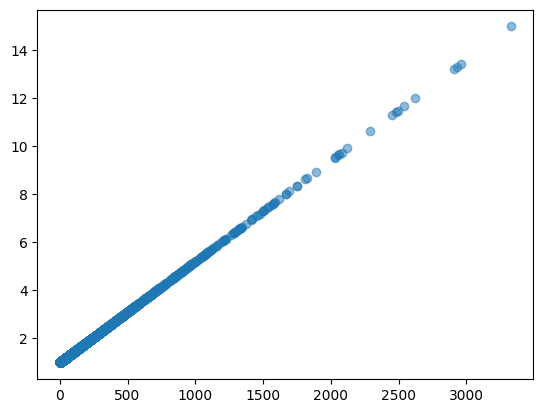

In [40]:
# draw width to see if it is linear
PLT.scatter(yb_route_weekday_tpc["sum_of_txn_times"], yb_route_weekday_tpc["width"], alpha=0.5)
PLT.show()


In [41]:
h3_agg["width"] = h3_agg.apply(
    lambda x: x["sum_of_txn_times"] * 15 / 3328, axis=1
)
h3_agg

,on_cell,off_cell,sum_of_txn_times,on_lat,on_lon,off_lat,off_lon,on_id,on_name,off_id,off_name,width
0,894ba0a4003ffff,894ba0a4003ffff,230,25.041169,121.517518,25.041169,121.517518,894ba0a4003ffff,894ba0a4003ffff,894ba0a4003ffff,894ba0a4003ffff,1.036659
1,894ba0a4003ffff,894ba0a400bffff,30,25.041169,121.517518,25.038326,121.516431,894ba0a4003ffff,894ba0a4003ffff,894ba0a400bffff,894ba0a400bffff,0.135216
2,894ba0a4003ffff,894ba0a400fffff,26,25.041169,121.517518,25.039162,121.519656,894ba0a4003ffff,894ba0a4003ffff,894ba0a400fffff,894ba0a400fffff,0.117188
3,894ba0a4003ffff,894ba0a4013ffff,44,25.041169,121.517518,25.043176,121.515380,894ba0a4003ffff,894ba0a4003ffff,894ba0a4013ffff,894ba0a4013ffff,0.198317
4,894ba0a4003ffff,894ba0a4017ffff,253,25.041169,121.517518,25.044012,121.518605,894ba0a4003ffff,894ba0a4003ffff,894ba0a4017ffff,894ba0a4017ffff,1.140325
...,...,...,...,...,...,...,...,...,...,...,...,...
127011,894ba5696dbffff,894ba5696c7ffff,10,25.128409,121.498606,25.130082,121.505056,894ba5696dbffff,894ba5696dbffff,894ba5696c7ffff,894ba5696c7ffff,0.045072
127012,894ba5696dbffff,894ba5696cbffff,237,25.128409,121.498606,25.126406,121.500744,894ba5696dbffff,894ba5696dbffff,894ba5696cbffff,894ba5696cbffff,1.068209
127013,894ba5696dbffff,894ba5696cfffff,7,25.128409,121.498606,25.127242,121.503968,894ba5696dbffff,894ba5696dbffff,894ba5696cfffff,894ba5696cfffff,0.031550
127014,894ba5696dbffff,894ba5696d3ffff,45,25.128409,121.498606,25.131249,121.499693,894ba5696dbffff,894ba5696dbffff,894ba5696d3ffff,894ba5696d3ffff,0.202825


In [42]:
h3_agg.describe()

,sum_of_txn_times,on_lat,on_lon,off_lat,off_lon,width
count,127016.000000,127016.000000,127016.000000,127016.000000,127016.000000,127016.000000
mean,22.240686,25.049634,121.543396,25.049918,121.542644,0.100243
std,100.641098,0.026620,0.027801,0.027538,0.028323,0.453611
min,1.000000,24.975061,121.462054,24.975061,121.462054,0.004507
25%,1.000000,25.032804,121.522991,25.032468,121.521867,0.004507
50%,3.000000,25.046506,121.541109,25.046684,121.540095,0.013522
75%,12.000000,25.061233,121.561590,25.062238,121.561478,0.054087
max,6906.000000,25.144940,121.623849,25.144940,121.623849,31.126803


In [43]:
h3_agg.dtypes

on_cell              object
off_cell             object
sum_of_txn_times      int32
on_lat              float64
on_lon              float64
off_lat             float64
off_lon             float64
on_id                object
on_name              object
off_id               object
off_name             object
width               float64
dtype: object

In [44]:
# combine two dataframes
final_df = PD.concat([yb_route_weekday_tpc.assign(unit="stop"), h3_agg.assign(unit="cell")])
final_df

,on_id,off_id,on_name,off_name,sum_of_txn_times,width,on_lat,on_lon,on_cell,off_lat,off_lon,off_cell,unit
0,U101001,U101001,捷運科技大樓站,捷運科技大樓站,332,2.392846,25.026050,121.543600,894ba0a432fffff,25.026050,121.543600,894ba0a432fffff,stop
1,U101001,U101002,捷運科技大樓站,復興南路二段273號前,109,1.454463,25.026050,121.543600,894ba0a432fffff,25.025650,121.543570,894ba0a432fffff,stop
2,U101001,U101003,捷運科技大樓站,國北教大實小東側門,98,1.408176,25.026050,121.543600,894ba0a432fffff,25.024290,121.541240,894ba0a432bffff,stop
3,U101001,U101004,捷運科技大樓站,和平公園東側,345,2.447550,25.026050,121.543600,894ba0a432fffff,25.023510,121.542820,894ba0a432fffff,stop
4,U101001,U101005,捷運科技大樓站,辛亥復興路口西北側,1028,5.321611,25.026050,121.543600,894ba0a432fffff,25.021530,121.542990,894ba0a5d93ffff,stop
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127011,894ba5696dbffff,894ba5696c7ffff,894ba5696dbffff,894ba5696c7ffff,10,0.045072,25.128409,121.498606,894ba5696dbffff,25.130082,121.505056,894ba5696c7ffff,cell
127012,894ba5696dbffff,894ba5696cbffff,894ba5696dbffff,894ba5696cbffff,237,1.068209,25.128409,121.498606,894ba5696dbffff,25.126406,121.500744,894ba5696cbffff,cell
127013,894ba5696dbffff,894ba5696cfffff,894ba5696dbffff,894ba5696cfffff,7,0.031550,25.128409,121.498606,894ba5696dbffff,25.127242,121.503968,894ba5696cfffff,cell
127014,894ba5696dbffff,894ba5696d3ffff,894ba5696dbffff,894ba5696d3ffff,45,0.202825,25.128409,121.498606,894ba5696dbffff,25.131249,121.499693,894ba5696d3ffff,cell


In [45]:
# export dataset
final_df.to_parquet("./parquet/yb_route_weekday_tpc.parquet")